In [40]:
# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
from skimage.feature import hog
%matplotlib inline

# Read & Visualize dataset

In [2]:
def get_dataset(path):
    images = []
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if '.DS_Store' not in file:
                images.append(os.path.join(subdir, file))
                
    return list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), images))

Num of vehicles =  8792
Num of non-vehicles =  8968


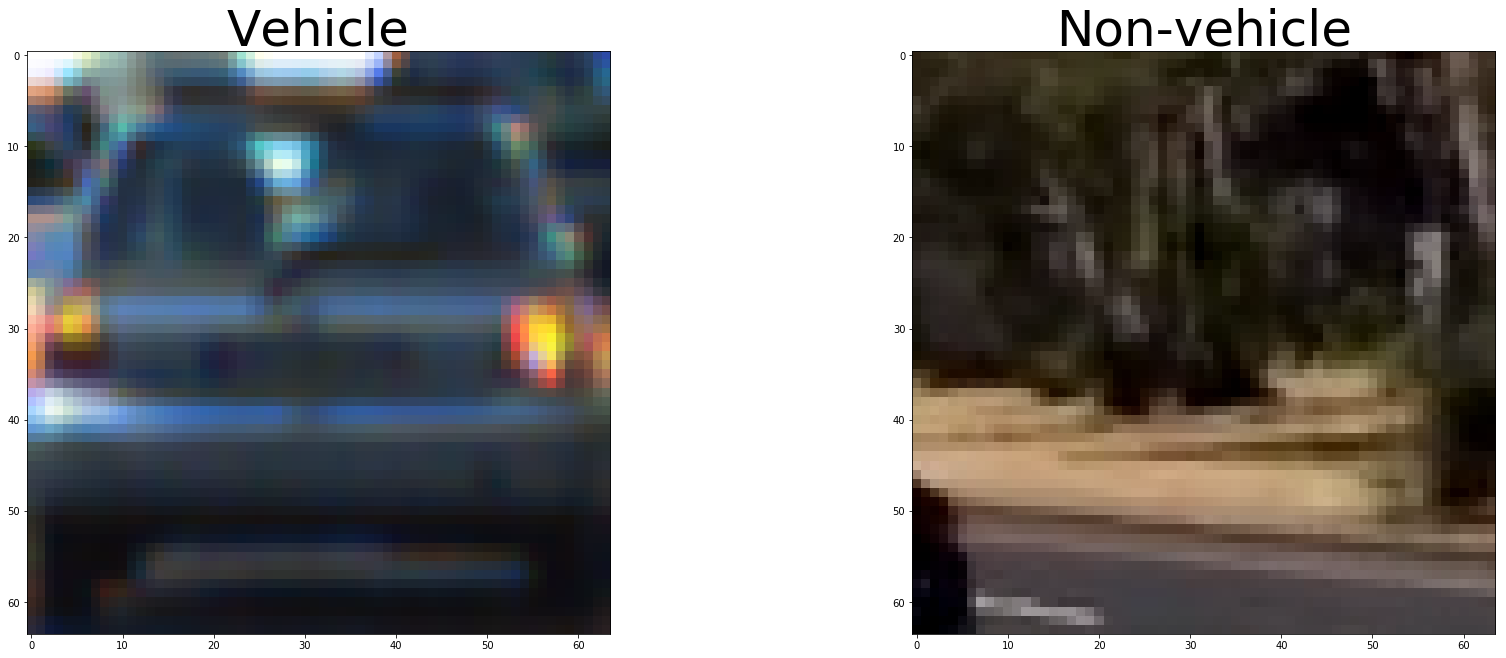

In [4]:
vehicle_dataset_path = './dataset/vehicles'
vehicles = get_dataset(vehicle_dataset_path)
non_vehicle_dataset_path = './dataset/non-vehicles'
non_vehicles = get_dataset(non_vehicle_dataset_path)
print("Num of vehicles = ", len(vehicles))
print("Num of non-vehicles = ", len(non_vehicles))

vehicle_sample = random.choice(vehicles)
non_vehicle_sample = random.choice(non_vehicles)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(vehicle_sample)
ax1.set_title("Vehicle", fontsize=50)
ax2.imshow(non_vehicle_sample)
ax2.set_title("Non-vehicle", fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Feature extraction

In [5]:
# define parameters for later use
params = {
            'color_space': 'YCrCb',
            'spatial_size': (16, 16),
            'orient': 8,
            'pix_per_cell': 8,
            'cell_per_block': 2,
            'hog_channel': 'ALL',
            'hist_bins': 32,
            'scale': 1.5,
            'spatial_feat': True, 
            'hist_feat': True, 
            'hog_feat': True
}

In [9]:
# Function to Convert image to desired color space
def convert_image(image, cspace):
    '''''
    Param: input image in RGB format
    Param: Desired image colorspace
    Returns: image in desired colorspace
    '''''
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image) 
        
    return feature_image

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [12]:
# extract features for a given image based on given params
def extract_features(img, params):
        file_features = []
        # convert to defined color space
        feature_image = convert_image(img, params["color_space"])    

        # extract spatial features
        if params["spatial_feat"] == True:
            spatial_features = bin_spatial(feature_image, size=params["spatial_size"])
            file_features.append(spatial_features)
        # extract color histogram details
        if params["hist_feat"] == True:
            hist_features = color_hist(feature_image, nbins=params["hist_bins"])
            file_features.append(hist_features)
        # extract hog features
        if params["hog_feat"] == True:
            if params["hog_channel"] == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        params["orient"], params["pix_per_cell"], params["cell_per_block"], 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,params.hog_channel], params["orient"], 
                            params["pix_per_cell"], params["cell_per_block"], vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
            
        # Return list of feature vectors
        return np.concatenate(file_features)

/home/kln/miniconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


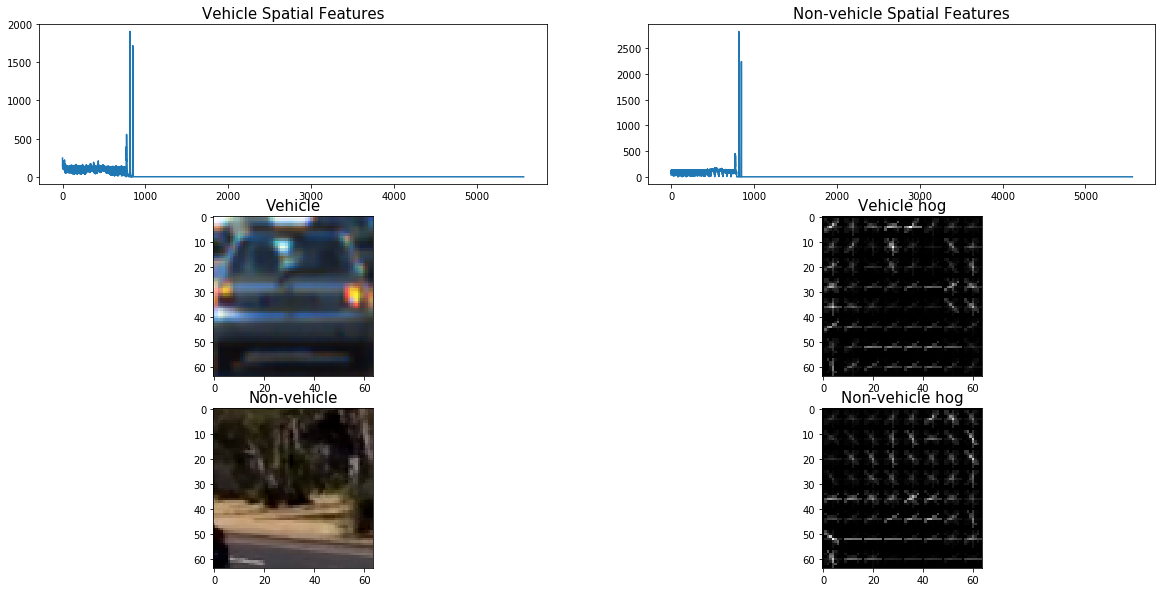

In [36]:
# test feature extraction

vehicle_spatial_features = extract_features(vehicle_sample, params)
non_vehicle_spatial_features = extract_features(non_vehicle_sample, params)

fig, plots = plt.subplots(nrows=3, ncols=2, figsize=(20,10))
(ax1, ax2, ax3, ax4, ax5, ax6) = plots.flatten()
ax1.plot((vehicle_spatial_features))
ax1.set_title("Vehicle Spatial Features",fontsize=15)

ax2.plot(non_vehicle_spatial_features)
ax2.set_title("Non-vehicle Spatial Features",fontsize=15)

f1,vehicle_hog = get_hog_features(vehicle_sample[:,:,0],params["orient"], params["pix_per_cell"], params["cell_per_block"], vis=True, feature_vec=True)
f2,non_vehicle_hog = get_hog_features(non_vehicle_sample[:,:,0],params["orient"], params["pix_per_cell"], params["cell_per_block"], vis=True, feature_vec=True)

ax3.set_title('Vehicle', fontsize=15)
ax3.imshow(vehicle_sample)
ax4.set_title('Vehicle hog', fontsize=15)
ax4.imshow(vehicle_hog, cmap='gray')
ax5.set_title('Non-vehicle', fontsize=15)
ax5.imshow(non_vehicle_sample)
ax6.set_title('Non-vehicle hog', fontsize=15)
ax6.imshow(non_vehicle_hog, cmap='gray')

# Support Vector Machine (SVM)

In [37]:
# implement SVM training

# define sample size to ensure equal number of vehicle & non-vehicle data for training
sample_size = 8750
vehicles = vehicles[0:sample_size]
non_vehicles = non_vehicles[0:sample_size]

# create feature lists
vehicle_features = list(map(lambda img: extract_features(img, params), vehicles))
non_vehicle_features = list(map(lambda img: extract_features(img, params), non_vehicles))


X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print("Training SVM with following params:")
print('orientations =', params['orient'])
print('pixels per cell and =', params['pix_per_cell'])
print('cells per block = ', params['cell_per_block'])
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# start time for SVC
t=time.time()
svc.fit(X_train, y_train)
# end time for SVC
t2 = time.time()
print('SVC training time = ', round(t2-t, 2))
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

/home/kln/miniconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Training SVM with following params:
orientations = 8
pixels per cell and = 8
cells per block =  2
Feature vector length: 5568
SVC training time =  6.17
Test Accuracy of SVC =  0.9951


# Identification of vehicles

In [42]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [43]:
def find_vehicles(img, svc, scaler, params, y_start_stop=[400, 700], xy_window=(64, 64), xy_overlap=(0.85, 0.85) ):
    """
    Returns the windows where the cars are found on the image `img`.
    The feature extraction used parameters `params`.
    `y_start_stop` : Contains the Y axis range to find the cars.
    `xy_window` : Contains the windows size.
    `xy_overlap` : Contains the windows overlap percent.
    Returns a new image with the cars boxes.
    """
    windows_list = []
    windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    for window in windows:
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features(img_window, params)
        scaled_features = scaler.transform(features.reshape(1, -1))
        pred = svc.predict(scaled_features)
        if pred == 1:
            windows_list.append(window)
    return windows_list

0


/home/kln/miniconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1
2
3
4
5


[]

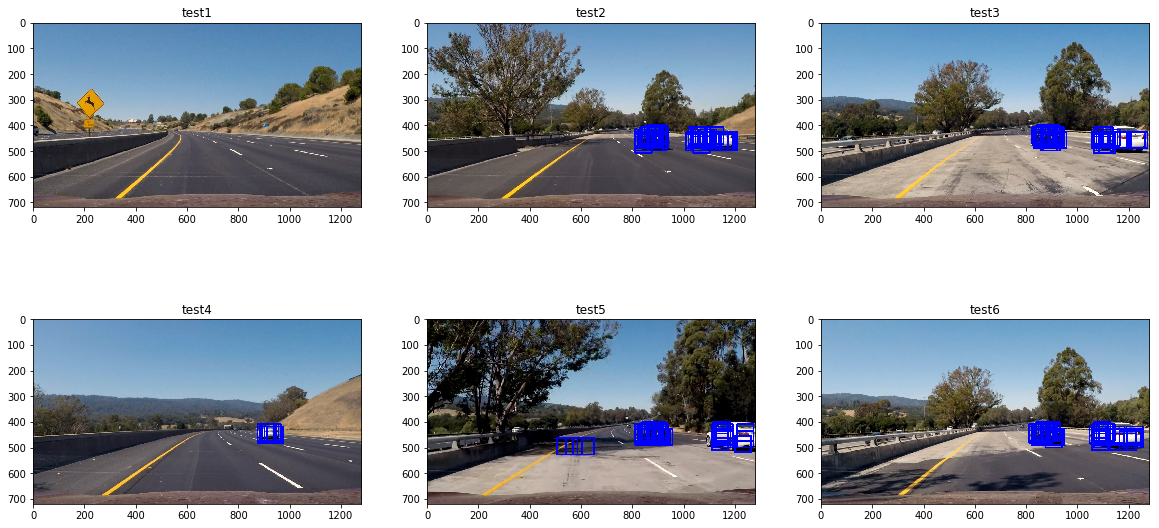

In [46]:
test_imgs = glob.glob('./test_images/test*.jpg')
fig, plots = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
plots = plots.flatten()

for i in range(0, len(test_imgs)):
    print("processing ", i)
    img = cv2.cvtColor(cv2.imread(test_imgs[i]), cv2.COLOR_BGR2RGB)
    windows_list = find_vehicles(img, svc, X_scaler, params)
    out_img = draw_boxes(img, windows_list)
    plots[i].imshow(out_img)
    plots[i].set_title('test' + str(i+1))

plt.plot()